In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import norm, lognorm
import statsmodels.api as sm

In [51]:
def K_gaussian(u):
    return (1/np.sqrt(2*np.pi))*np.exp(-(u**2)/2)

In [52]:
def K_epan(u):
    return (np.abs(u) < np.sqrt(5))*(3/(4*np.sqrt(5)))*(1 - (u**2)/5)

In [53]:
def kern_est(X, Kfun=K_epan, h=1, size=1000):
    xmin, xmax = np.min(X)-2*np.std(X), np.max(X)+2*np.std(X)
    n = X.shape[0]
    f = np.empty((size))
    for xi, xval in enumerate(np.linspace(xmin, xmax, size)):
        f[xi] = np.sum(Kfun((xval - X)/h))/(n*h)
    return f, np.linspace(xmin, xmax, size)

In [54]:
df = pd.read_stata(r"cattaneo2.dta")
df.head()

,bweight,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,...,order,msmoke,mbsmoke,mrace,frace,prenatal,birthmonth,lbweight,fbaby,prenatal1
0,3459,married,0,0,0,0,0,24,14,28,...,2,0 cigarettes daily,nonsmoker,1,1,1,12,0,No,Yes
1,3260,notmarried,0,0,1,0,0,20,10,0,...,3,0 cigarettes daily,nonsmoker,0,0,1,7,0,No,Yes
2,3572,married,0,0,1,0,0,22,9,30,...,3,0 cigarettes daily,nonsmoker,1,1,1,3,0,No,Yes
3,2948,married,0,0,0,0,0,26,12,30,...,2,0 cigarettes daily,nonsmoker,1,1,1,1,0,No,Yes
4,2410,married,0,0,0,0,0,20,12,21,...,1,0 cigarettes daily,nonsmoker,1,1,1,3,1,Yes,Yes


In [55]:
df.columns

Index(['bweight', 'mmarried', 'mhisp', 'fhisp', 'foreign', 'alcohol',
       'deadkids', 'mage', 'medu', 'fage', 'fedu', 'nprenatal', 'monthslb',
       'order', 'msmoke', 'mbsmoke', 'mrace', 'frace', 'prenatal',
       'birthmonth', 'lbweight', 'fbaby', 'prenatal1'],
      dtype='object')

In [56]:
#(a) Restrict sample to white and non-hispanic mothers
df_r = df[(df["mhisp"]==0) & (df["mrace"]==1)]

In [57]:
#np.logspace(-1, 3, 5).astype(float)

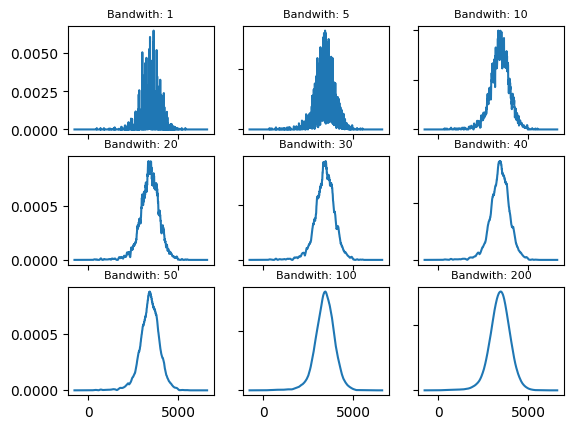

In [58]:
#(b) bweight kde. Using Epanechnikov kernel function
bw = df_r["bweight"]
size=1000
hlist = [1, 5, 10, 20, 30, 40, 50, 100, 200]
fig, axs = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        hval = hlist[i*3+j]
        kernest_y, xaxis = kern_est(bw, h=hval, size=size)
        axs[i, j].plot(xaxis, kernest_y)
        axs[i, j].set_title(f"Bandwith: {hval}", size=8)

for ax in axs.flat:
    ax.label_outer()

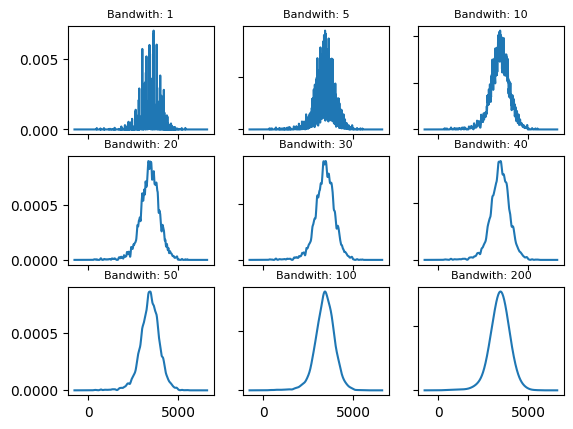

In [59]:
fig, axs = plt.subplots(3, 3) #using the Gaussian kernel

for i in range(3):
    for j in range(3):
        hval = hlist[i*3+j]
        kernest_y, xaxis = kern_est(bw, Kfun=K_gaussian, h=hval, size=size)
        axs[i, j].plot(xaxis, kernest_y)
        axs[i, j].set_title(f"Bandwith: {hval}", size=8)

for ax in axs.flat:
    ax.label_outer()

### $(b)$
The bandwith that preserves features of the data while smoothing the data enough to be informative is somewhere between 40 and 50. This is robust to relying on Epanechnikov or Gaussian kernel. We will keep a bw of 45 next.

### $(c)$ and $(d)$


In [65]:
#kde
fhat, xaxis = kern_est(bw, h=45, size=1000)

In [66]:
#normal
m1 = np.mean(bw)
m2 = np.std(bw)

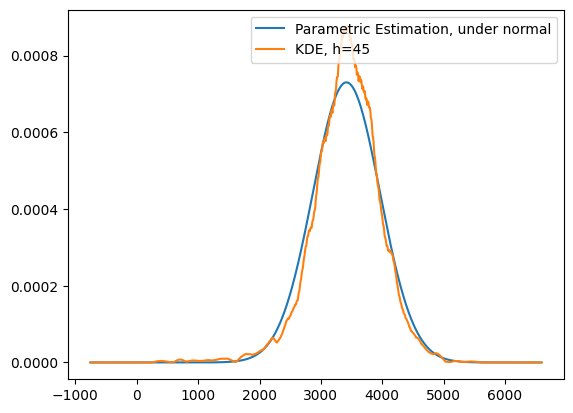

In [67]:
plt.plot(xaxis, norm(m1, m2).pdf(xaxis), label="Parametric Estimation, under normal")
plt.plot(xaxis, fhat, label=f"KDE, h={45}")
plt.legend()
plt.show()

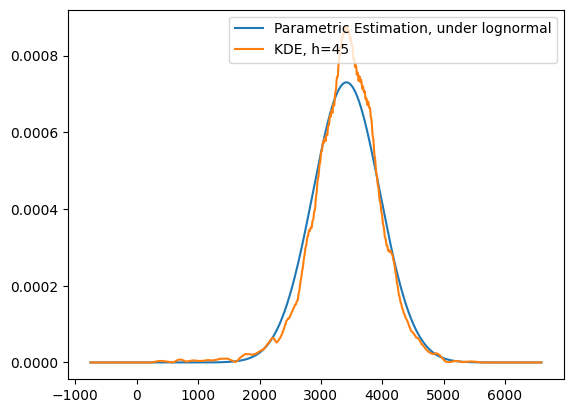

In [68]:
#lognormal
m1log, m2log, tlog = lognorm.fit(bw)

plt.plot(xaxis, lognorm(m1log, m2log, tlog).pdf(xaxis), label="Parametric Estimation, under lognormal")
plt.plot(xaxis, fhat, label=f"KDE, h={45}")
plt.legend()
plt.show()

Both normality and lognormality seem reasonable.

In [69]:
mage = df_r["mage"]

In [70]:
KernReg = sm.nonparametric.KernelReg

In [ ]:
z=KernReg(bw, mage, var_type="c")
bwpred = z.fit(mage)[0]

In [ ]:
print(z)
print(f"Bandwith value: {z.bw}")
#By default, sm.nonparametric.KernelReg uses Gaussian Kernel

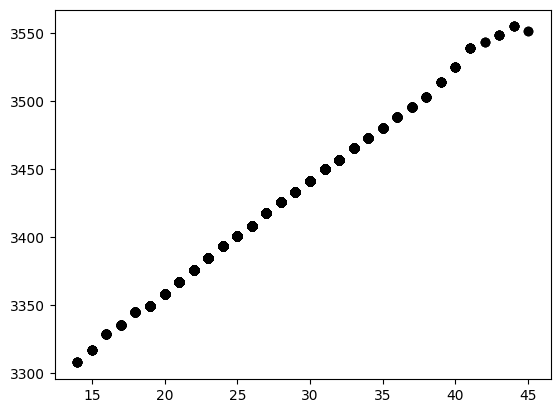

In [30]:
pred_df = pd.DataFrame(np.array([mage, bwpred]).T)
pred_df.columns = ["mage", "bwpred"]

#plt.scatter(df_r["mage"], df_r["bweight"], color="teal", alpha=0.2)
plt.scatter(pred_df["mage"], pred_df["bwpred"], color="black")
plt.show() #There seems to be a weak positive relationship between mother age and baby weight at birth.

### $(f)$: Series estimation


In [31]:
mage_poly = np.array(mage, dtype=float).reshape(-1, 1)**np.arange(10)
model_series = sm.OLS(bw, mage_poly).fit()

In [32]:
bwpred_series = model_series.predict(mage_poly)

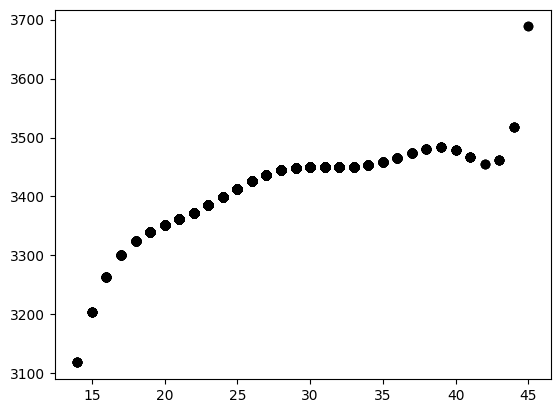

In [34]:
predseries_df = pd.DataFrame(np.array([mage, bwpred_series]).T)
predseries_df.columns = ["mage", "bwpred"]

#plt.scatter(df_r["mage"], df_r["bweight"], color="teal", alpha=0.2)
plt.scatter(predseries_df["mage"], predseries_df["bwpred"], color="black")
plt.show()

Problem: here we chose our value for the number of polynomials a bit randomly. If we pick a much higher value, we obtain a completely different estimate.

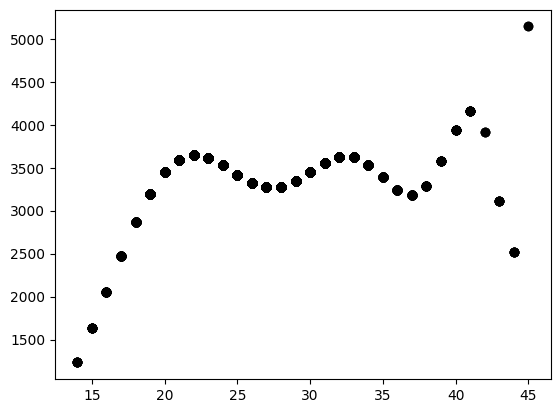

In [35]:
mage_poly2 = np.array(mage, dtype=float).reshape(-1, 1)**np.arange(15)
model_series2 = sm.OLS(bw, mage_poly2).fit()
bwpred_series2 = model_series2.predict(mage_poly2)
predseries_df2 = pd.DataFrame(np.array([mage, bwpred_series2]).T)
predseries_df2.columns = ["mage", "bwpred2"]

#plt.scatter(df_r["mage"], df_r["bweight"], color="teal",alpha=0.2)
plt.scatter(predseries_df2["mage"], predseries_df2["bwpred2"], color="black")
plt.show()

So I implement a simple cross validation, in order to determine the number of polynomials that gives us the best out of sample $R^2$

In [39]:
def cross_validation(estimator, y, X, param_grid):
    """Admittedly, not the most general implementation.
       Returns the list of R^2 obtained, and the parameter value
       that maximizes the out-of-sample R^2."""
    R2list = np.empty((param_grid.shape[0], 1))
    for i, param in enumerate(param_grid):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train_poly = np.array(X_train, dtype=float).reshape(-1, 1)**np.arange(param)
        X_test_poly = np.array(X_test, dtype=float).reshape(-1, 1)**np.arange(param)
        
        reg = estimator(y_train, X_train_poly).fit()
        ypred = reg.predict(X_test_poly)
        R2list[i] = r2_score(y_test, ypred)
    return R2list, param_grid[np.argmax(R2list)]

In [47]:
p_grid =  np.arange(1, 15)
simu_cv = cross_validation(sm.OLS, mage, bw, p_grid)
p_opt = p_grid[simu_cv[1]] #=5
print(p_opt)

3


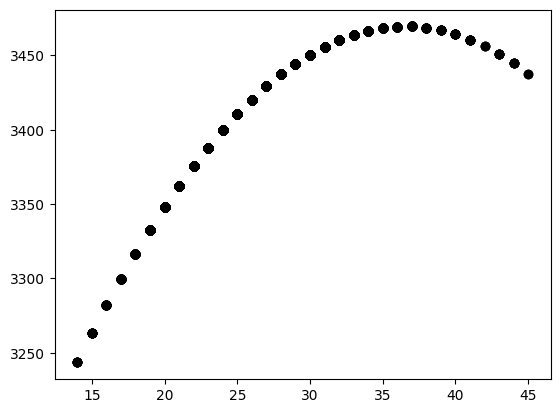

In [41]:
mage_polycv = np.array(mage, dtype=float).reshape(-1, 1)**np.arange(p_opt)
model_seriescv = sm.OLS(bw, mage_polycv).fit()
bwpred_seriescv = model_seriescv.predict(mage_polycv)
predseries_dfcv = pd.DataFrame(np.array([mage, bwpred_seriescv]).T)
predseries_dfcv.columns = ["mage", "bwpred2"]

#plt.scatter(df_r["mage"], df_r["bweight"], color="teal", alpha=0.2)
plt.scatter(predseries_dfcv["mage"], predseries_dfcv["bwpred2"], color="black")
plt.show()

### $(g)$

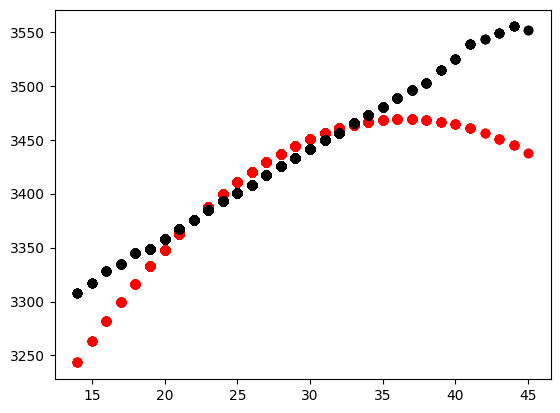

In [49]:
#plt.scatter(df_r["mage"], df_r["bweight"], color="teal", alpha=0.2)
plt.scatter(predseries_dfcv["mage"], predseries_dfcv["bwpred2"], color="r")
plt.scatter(pred_df["mage"], pred_df["bwpred"], color="black")
plt.show() #

### $(h)$

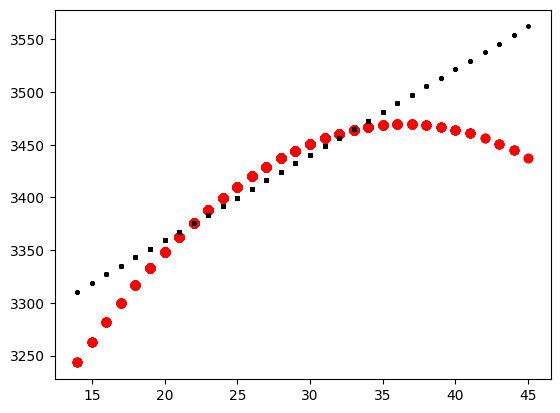

In [46]:
magelin = sm.add_constant(mage)

model_linear = sm.OLS(bw, magelin).fit()
bwpred_linear = model_linear.predict(magelin)

predlinear = pd.DataFrame(np.array([mage, bwpred_linear]).T)
predlinear.columns = ["mage", "bwpredlin"]

#plt.scatter(df_r["mage"], df_r["bweight"], color="teal", alpha=0.2)
plt.scatter(predseries_dfcv["mage"], predseries_dfcv["bwpred2"], color="r", label="Nonparametric")
plt.scatter(predlinear["mage"], predlinear["bwpredlin"], color="black", label="Linear", s=5)
plt.show()
#Yes, linearity sounds completely reasonable in this case

### $(i)$

In [43]:
mage_quadr = np.array(mage, dtype=float).reshape(-1, 1)**np.arange(3)
mage_quadr

array([[  1.,  24., 576.],
       [  1.,  22., 484.],
       [  1.,  26., 676.],
       ...,
       [  1.,  30., 900.],
       [  1.,  23., 529.],
       [  1.,  22., 484.]])

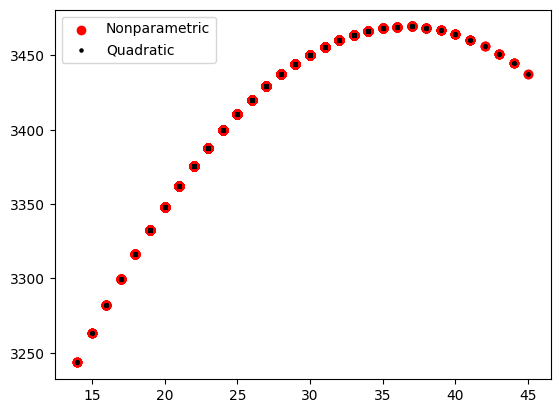

In [45]:
mage_quadr = np.array(mage, dtype=float).reshape(-1, 1)**np.arange(3)
model_quadr = sm.OLS(bw, mage_quadr).fit()
bwpred_quadr = model_quadr.predict(mage_quadr)
pred_quadr = pd.DataFrame(np.array([mage, bwpred_quadr]).T)
pred_quadr.columns = ["mage", "bwpred_quadr"]

#plt.scatter(df_r["mage"], df_r["bweight"], color="teal", alpha=0.2)
plt.scatter(predseries_dfcv["mage"], predseries_dfcv["bwpred2"], color="r", label="Nonparametric")
plt.scatter(pred_quadr["mage"], pred_quadr["bwpred_quadr"], color="black", s=5, label="Quadratic")
#plt.plot(predlinear["mage"], predlinear["bwpredlin"], color="blue")
plt.legend()
plt.show() #the Quadratic fit is remarkably consistent with the nonparametric one, except at the 
           #right end of the age distribution, which makes sense given the low number of observation in that area
           #For me, quadratic fit is the one that yields the best tradeoff between fit and interpretability.

In [31]:
#Neural Network Nonparametric estimation: a simple application of Pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

class network(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(network, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x)
        x = self.layer2(x)
        x = F.tanh(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        return x

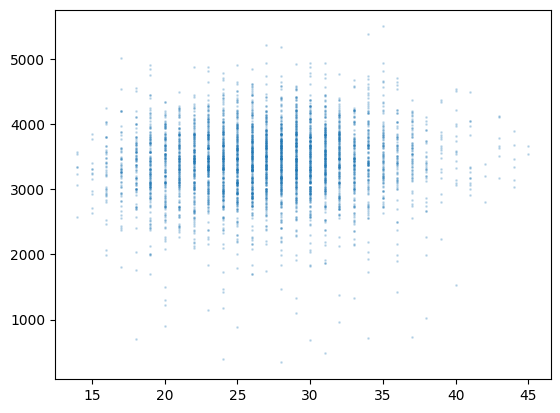

In [32]:
x = torch.tensor(np.array(mage)).to(torch.float32).reshape(-1, 1)
y = torch.tensor(np.array(bw)).to(torch.float32).reshape(-1, 1)
plt.scatter(x, y, s=1, alpha=0.2)

In [33]:
torch.manual_seed(42)

input_size = 1  # Number of input features
output_size = 1  # Number of output features
hidden_size = 128
learning_rate = 0.01


model = network(input_size, output_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 4000
for epoch in range(num_epochs):
    outputs = model(x)
    loss = criterion(outputs, y)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/4000], Loss: 299915.4688
Epoch [200/4000], Loss: 298585.5625
Epoch [300/4000], Loss: 298582.2188
Epoch [400/4000], Loss: 298579.8438
Epoch [500/4000], Loss: 298578.4375
Epoch [600/4000], Loss: 298577.5000
Epoch [700/4000], Loss: 298576.8438
Epoch [800/4000], Loss: 298576.3125
Epoch [900/4000], Loss: 298575.9375
Epoch [1000/4000], Loss: 298627.1562
Epoch [1100/4000], Loss: 299813.7812
Epoch [1200/4000], Loss: 298479.6250
Epoch [1300/4000], Loss: 296459.7812
Epoch [1400/4000], Loss: 296335.6250
Epoch [1500/4000], Loss: 296314.7500
Epoch [1600/4000], Loss: 296308.9062
Epoch [1700/4000], Loss: 296287.1562
Epoch [1800/4000], Loss: 296278.4688
Epoch [1900/4000], Loss: 296272.9062
Epoch [2000/4000], Loss: 296269.0000
Epoch [2100/4000], Loss: 296267.8750
Epoch [2200/4000], Loss: 296264.9062
Epoch [2300/4000], Loss: 296263.7188
Epoch [2400/4000], Loss: 296262.9688
Epoch [2500/4000], Loss: 296262.2500
Epoch [2600/4000], Loss: 296262.0000
Epoch [2700/4000], Loss: 296261.4375
Epoch [280

In [34]:
X_test = torch.tensor(np.array(mage).reshape(-1, 1)).to(torch.float32)
with torch.no_grad():
    predictions = model(X_test)

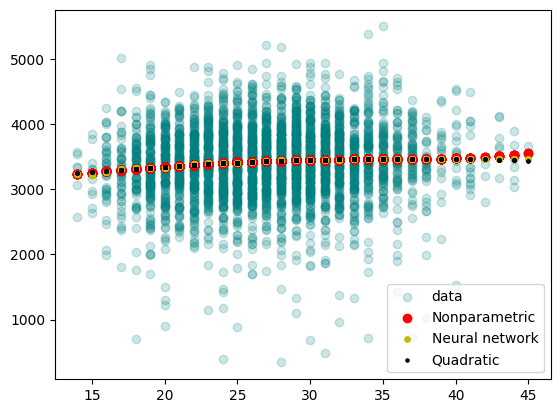

In [35]:
plt.scatter(x, y, label="data", color="teal", alpha=0.2)
plt.scatter(predseries_dfcv["mage"], predseries_dfcv["bwpred2"], color="r", label="Nonparametric")
plt.scatter(X_test, predictions, c="y", label="Neural network", s=15)
plt.scatter(pred_quadr["mage"], pred_quadr["bwpred_quadr"], color="black", s=5, label="Quadratic")
plt.legend()
plt.show()

This seems to provide an additional argument in favour of the quadratic model. The neural network and quadratic models yield almost identical predictions.